## Genz Function in Dakota and QMCPy 

A QMCPy implementation and comparison of [Dakota's Genz function](https://dakota.sandia.gov/sites/default/files/docs/6.17.0-release/user-html/usingdakota/examples/additionalexamples.html?highlight=genz#genz-functions)

In [1]:
from numpy import *
from qmcpy import *
import pandas as pd
from matplotlib import pyplot
import tempfile
import os
import subprocess
import numpy as np
%matplotlib inline

In [2]:
kinds_func = ['oscillatory','corner-peak']
kinds_coeff = [1,2,3]
ds = 2**arange(8)
ns = 2**arange(7,19)
ds

array([  1,   2,   4,   8,  16,  32,  64, 128])

In [3]:
ref_sols = {}
print('logging: ',end='',flush=True)
x_full = DigitalNetB2(ds.max(),seed=7).gen_samples(2**22)
for kind_func in kinds_func:
    for kind_coeff in kinds_coeff:
        tag = '%s.%d'%(kind_func,kind_coeff)
        print('%s, '%tag,end='',flush=True)
        mu_hats = zeros(len(ds),dtype=float)
        for j,d in enumerate(ds):
            genz = Genz(IIDStdUniform(d),kind_func=kind_func,kind_coeff=kind_coeff)
            y = genz.f(x_full[:,:d])
            mu_hats[j] = y.mean()
        ref_sols[tag] = mu_hats
print()
ref_sols = pd.DataFrame(ref_sols)
ref_sols['d'] = ds
ref_sols.set_index('d',inplace=True)
ref_sols

logging: oscilatory.1, oscilatory.2, oscilatory.3, corner-peak.1, corner-peak.2, corner-peak.3, 


,oscilatory.1,oscilatory.2,oscilatory.3,corner-peak.1,corner-peak.2,corner-peak.3
d,,,,,,
1,-0.217229,-0.217229,-0.217229,8.000000e-01,0.800000,0.800000
2,-0.350528,-0.379658,-0.217290,7.133127e-01,0.712088,0.719996
4,-0.472868,-0.472147,-0.223335,5.663464e-01,0.566334,0.589674
8,-0.545580,-0.526053,-0.276837,3.573127e-01,0.360014,0.402641
16,-0.585497,-0.558159,-0.390467,1.423258e-01,0.147353,0.185776
32,-0.606470,-0.577987,-0.492894,2.259072e-02,0.025678,0.038375
64,-0.617228,-0.590764,-0.556348,5.692751e-04,0.000879,0.001606
128,-0.622677,-0.599348,-0.591170,3.614889e-07,0.000001,0.000003


In [4]:
# with tempfile.TemporaryDirectory() as tmp:
#     with open(os.path.join(tmp, "dakota.in"), "w") as io:
#         io.write(f"environment\
#             \ttabular_data\n\
#             method\
#             \tfsu_quasi_mc halton\
#             \t\tsamples = {ns.max()}\
#             \toutput silent\n\
#             variables\
#             \tcontinuous_design = {ds.max()}\
#             \tlower_bounds = {' '.join(['0.0' for _ in range(ds.max())])}\
#             \tupper_bounds = {' '.join(['1.0' for _ in range(ds.max())])}\n\
#             interface\
#             \tfork\
#             \t\tanalysis_driver = 'dummy'\
#             \tbatch\
#             \twork_directory named 'work'\n\
#             responses\
#             \tobjective_functions = 1\
#             \tno_gradients\
#             \tno_hessians"
#         )
#     subprocess.run(["dakota", "dakota.in"], cwd=tmp, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#     file = os.listdir(os.path.join(tmp, "work"))[0]
#     with open(os.path.join(tmp, "work", file), "r") as io:
#         lines = io.readlines()
#         x_full_dakota = []
#         for n, line in enumerate(lines):
#             if f"{ds.max()} variables" in line:
#                 x_full_dakota.append([float(lines[n + 1 + j].split()[0]) for j in range(ds.max())])
#         x_full_dakota = np.vstack(x_full_dakota)
x_full_dakota = np.loadtxt("x_full_dakota.txt")

In [5]:
n_max,d_max = ns.max(),ds.max()
pts = {
    'IID Standard Uniform': IIDStdUniform(d_max).gen_samples(n_max),
    'Lattice (random shift)': Lattice(d_max).gen_samples(n_max),
    'Digital Net (random scramble + shift)': DigitalNetB2(d_max).gen_samples(n_max),
    'Halton (not random, not general)': Halton(d_max,randomize=False,generalize=False).gen_samples(n_max,warn=False),
    'Halton (not random, general)': Halton(d_max,randomize=False,generalize=True).gen_samples(n_max,warn=False),
    'Halton (random, not general)': Halton(d_max,randomize=True,generalize=False).gen_samples(n_max),
    'Halton (random, general)': Halton(d_max,randomize=True,generalize=True).gen_samples(n_max),
    'Halton (Dakota)': x_full_dakota[:n_max,:d_max]
}

logging
IID Standard Uniform d: 1, 2, 4, 8, 16, 32, 64, 128, 
Lattice (random shift) d: 1, 2, 4, 8, 16, 32, 64, 128, 
Digital Net (random scramble + shift) d: 1, 2, 4, 8, 16, 32, 64, 128, 
Halton (not random, not general) d: 1, 2, 4, 8, 16, 32, 64, 128, 
Halton (not random, general) d: 1, 2, 4, 8, 16, 32, 64, 128, 
Halton (random, not general) d: 1, 2, 4, 8, 16, 32, 64, 128, 
Halton (random, general) d: 1, 2, 4, 8, 16, 32, 64, 128, 
     Halton (Dakota) d: 1, 2, 4, 8, 16, 32, 64, 128, 


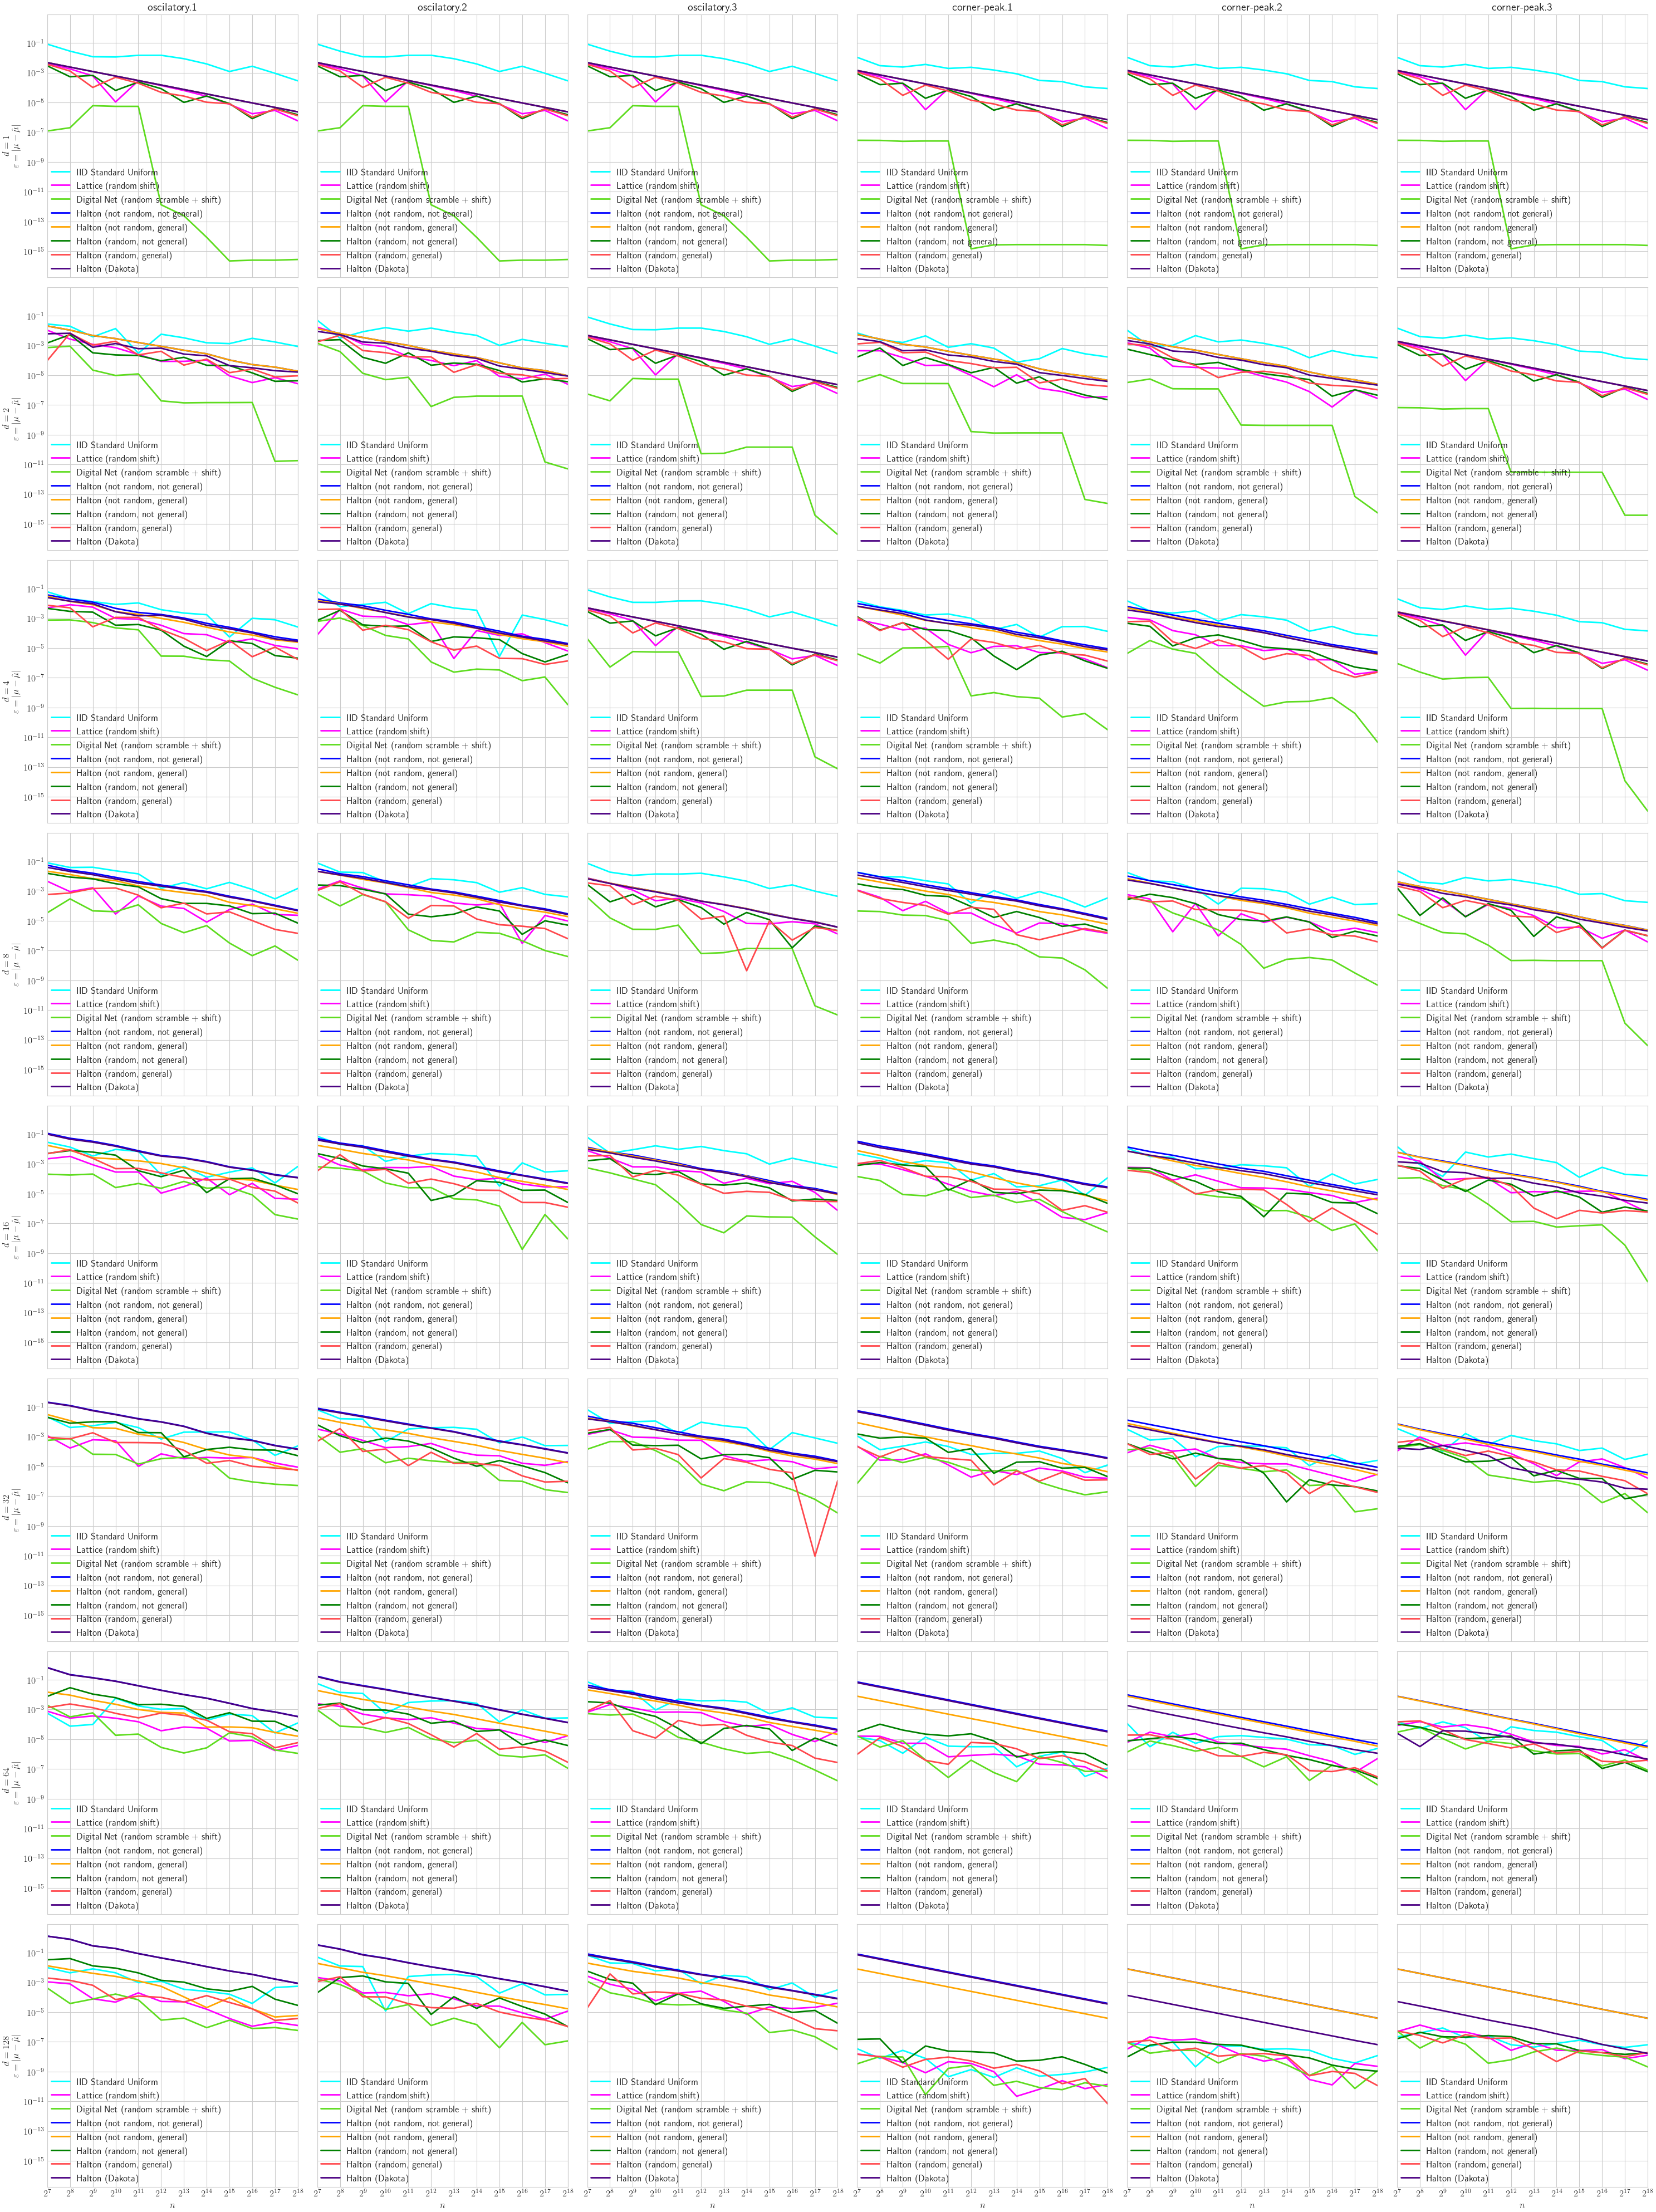

In [6]:
nrows = len(ds)
ncols = len(kinds_func)*len(kinds_coeff)
print('logging')
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(ncols*5,nrows*5),sharey=True,sharex=True)
ax = ax.reshape(nrows,ncols)
colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color'] + ["indigo"]
for v,(name,x_full) in enumerate(pts.items()):
    print('%20s d: '%name,end='',flush=True)
    for j,d in enumerate(ds):
        print('%d, '%d,end='',flush=True)
        for i1,kind_func in enumerate(kinds_func):
            for i2,kind_coeff in enumerate(kinds_coeff):
                i = len(kinds_coeff)*i1+i2
                tag = '%s.%d'%(kind_func,kind_coeff)
                genz = Genz(IIDStdUniform(d),kind_func=kind_func,kind_coeff=kind_coeff)
                y_full = genz.f(x_full[:,:d])
                mu_hats = array([y_full[:n].mean() for n in ns],dtype=float)
                error = abs(mu_hats-ref_sols.loc[d,tag])
                ax[j,i].plot(ns,error,label=name, color=colors[v])
                if v==(len(pts)-1): ax[j,i].legend(loc='lower left')
                if v>0: continue
                ax[j,i].set_xscale('log',base=2)
                ax[j,i].set_yscale('log',base=10)
                if i==0: ax[j,i].set_ylabel(r'$d=%d$\\$\varepsilon = \lvert \mu - \hat{\mu} \rvert$'%d)
                if j==0: ax[j,i].set_title(tag)
                if j==(len(ds)-1): 
                    ax[j,i].set_xlabel(r'$n$')
                    ax[j,i].set_xticks(ns)
                    ax[j,i].set_xlim([ns.min(),ns.max()])
    print()